In [1]:
# Cell 0: Setup & SABR Data Loading
# ====================================

import sys, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.dpi': 120, 'font.size': 10})

project_root = Path.cwd().parent if Path.cwd().name == 'signals' else Path.cwd()
sys.path.insert(0, str(project_root / 'signals' / 'scripts'))
sys.path.insert(0, str(project_root / 'src'))

from fx_skew_divergence import (
    load_pair_data, build_divergence_signal,
    PAIR_CONFIGS, SPOT_SIGN, CURRENCIES, PAIR_MAP,
)
from fx_options.sabr import sabr_implied_vol
from fx_options.black76 import black76_price
from backtesting.metrics import PerformanceMetrics

DATA_DIR = Path.home() / 'trade_data' / 'ETFTrader'

# --- Load signal data for all 3 pairs ---
pair_data = {}
for ccy in CURRENCIES:
    config = PAIR_CONFIGS[ccy]
    df, mask_both, info = load_pair_data(ccy)
    bull_mask, bear_mask, _, _, sig_info = build_divergence_signal(df, mask_both, config)

    direction = config['trade_direction']
    signal_mask = bull_mask if direction == 'bull' else bear_mask

    signal_dates = df.loc[signal_mask, 'date'].values
    pair_data[ccy] = {
        'df': df, 'config': config, 'signal_dates': signal_dates,
        'direction': direction, 'n_signals': len(signal_dates),
    }
    print(f"{PAIR_MAP[ccy]}: {len(signal_dates)} {direction} signals, hold={config['hold_days']}d")

# --- Load FULL SABR data for option pricing ---
# Use 1M for entry (100% coverage on all signal dates) and 1M/3M for exit
sabr_raw = pd.read_parquet(DATA_DIR / 'fx_sabr' / 'sabr_params_historical.parquet')
sabr_raw['date'] = pd.to_datetime(sabr_raw['timestamp']).dt.normalize()

sabr_lookup = {}
for ccy in CURRENCIES:
    sabr_lookup[ccy] = {}
    for tenor in ['1W', '2W', '1M', '3M']:
        sub = sabr_raw[(sabr_raw['currency'] == ccy) & (sabr_raw['tenor_bucket'] == tenor)].copy()
        sub = sub.sort_values('date').drop_duplicates('date', keep='first')
        sub = sub.set_index('date')[['forward', 'alpha', 'rho', 'nu', 'T', 'dte']]
        sabr_lookup[ccy][tenor] = sub

print(f"\nSABR lookup built.")

# --- Option config ---
# 1M entry for all pairs (100% signal date coverage), 1M exit with 3M fallback
OPTION_CONFIG = {
    'EUR': {'entry_tenor': '1M', 'exit_tenor': '1M', 'exit_fallback': '3M'},
    'GBP': {'entry_tenor': '1M', 'exit_tenor': '1M', 'exit_fallback': '3M'},
    'JPY': {'entry_tenor': '1M', 'exit_tenor': '1M', 'exit_fallback': '3M'},
}

# Transaction cost: half-spread as % of mid price, charged at entry AND exit.
# G10 1M ATM vanilla: institutional bid-offer ~0.2-0.4 vol pts, ≈ 3-5% of premium.
# We use 5% (conservative) for the base case.
COST_PCT = 0.05

print(f'Transaction cost: {COST_PCT*100:.0f}% of mid per leg (conservative institutional estimate)')
print('Setup complete.')

EURUSD: 23 bull signals, hold=5d
GBPUSD: 24 bull signals, hold=5d
USDJPY: 35 bear signals, hold=10d

SABR lookup built.
Transaction cost: 5% of mid per leg (conservative institutional estimate)
Setup complete.


In [2]:
# Cell 1: Option Pricing Engine
# ================================
#
# Two strategies:
#  1. Outright call/put (ATM, 1M option, close after hold period)
#     - Delta ≈ 0.5, captures ~half the move
#     - Premium ≈ 30-50 bps → natural leverage on premium
#  2. Risk reversal (25-delta call + short 25-delta put)
#     - Near-zero net cost, full delta exposure
#     - Highest leverage (on margin)

def get_sabr_row(ccy, tenor, date):
    """Look up SABR params for (currency, tenor, date)."""
    lookup = sabr_lookup[ccy][tenor]
    if date in lookup.index:
        return lookup.loc[date]
    for offset in [pd.Timedelta(days=1), pd.Timedelta(days=-1),
                   pd.Timedelta(days=2), pd.Timedelta(days=-2)]:
        alt = date + offset
        if alt in lookup.index:
            return lookup.loc[alt]
    return None


def get_sabr_row_with_fallback(ccy, tenor, fallback, date):
    """Try primary tenor, fall back to secondary."""
    row = get_sabr_row(ccy, tenor, date)
    if row is not None:
        return row
    return get_sabr_row(ccy, fallback, date)


def price_at_strike(sabr_row, K, is_call, T_override=None):
    """Price an option using SABR IV + Black-76."""
    F = sabr_row['forward']
    T = T_override if T_override is not None else sabr_row['T']
    if T <= 0:
        T = 1 / 365
    sigma = sabr_implied_vol(F, K, T, sabr_row['alpha'], sabr_row['rho'], sabr_row['nu'])
    if sigma <= 0 or np.isnan(sigma):
        return np.nan
    return black76_price(F, K, T, sigma, is_call)


def find_25delta_strikes(F, sigma, T):
    """Approximate 25-delta call and put strikes."""
    sqrt_T = np.sqrt(max(T, 1/365))
    K_call = F * np.exp(0.6745 * sigma * sqrt_T + 0.5 * sigma**2 * T)
    K_put = F * np.exp(-0.6745 * sigma * sqrt_T + 0.5 * sigma**2 * T)
    return K_call, K_put


def compute_trade_pnl(ccy, signal_date, hold_days, is_call):
    """Compute P&L for outright option + risk reversal strategies.
    
    is_call: True for bull (forward UP), False for bear (forward DOWN).
    
    Exit re-pricing uses T_remaining = T_entry - hold_days/365 with
    exit-date SABR params for alpha/rho/nu/forward.
    """
    opt_cfg = OPTION_CONFIG[ccy]
    entry_date = pd.Timestamp(signal_date)
    exit_date = entry_date + pd.Timedelta(days=hold_days)
    
    entry_sabr = get_sabr_row(ccy, opt_cfg['entry_tenor'], entry_date)
    exit_sabr = get_sabr_row_with_fallback(
        ccy, opt_cfg['exit_tenor'], opt_cfg['exit_fallback'], exit_date)
    
    if entry_sabr is None or exit_sabr is None:
        return None
    if entry_sabr['alpha'] < 0.01 or exit_sabr['alpha'] < 0.01:
        return None
    
    F_entry = entry_sabr['forward']
    F_exit = exit_sabr['forward']
    T_entry = entry_sabr['T']
    T_remaining = max(T_entry - hold_days / 365, 1 / 365)
    
    # ===== OUTRIGHT CALL/PUT (ATM) =====
    K_atm = F_entry
    
    opt_entry = price_at_strike(entry_sabr, K_atm, is_call)
    opt_exit = price_at_strike(exit_sabr, K_atm, is_call, T_override=T_remaining)
    if np.isnan(opt_entry) or np.isnan(opt_exit) or opt_entry <= 0:
        return None
    
    opt_gross_pnl = opt_exit - opt_entry
    opt_cost_tc = COST_PCT * (opt_entry + opt_exit)
    opt_net_pnl = opt_gross_pnl - opt_cost_tc
    
    # ===== RISK REVERSAL (25-delta) =====
    sigma_atm = entry_sabr['alpha']
    K_call_25d, K_put_25d = find_25delta_strikes(F_entry, sigma_atm, T_entry)
    
    if is_call:
        rr_long_K, rr_short_K = K_call_25d, K_put_25d
        rr_long_is_call, rr_short_is_call = True, False
    else:
        rr_long_K, rr_short_K = K_put_25d, K_call_25d
        rr_long_is_call, rr_short_is_call = False, True
    
    rr_long_entry = price_at_strike(entry_sabr, rr_long_K, rr_long_is_call)
    rr_short_entry = price_at_strike(entry_sabr, rr_short_K, rr_short_is_call)
    if np.isnan(rr_long_entry) or np.isnan(rr_short_entry):
        return None
    
    rr_entry_cost = rr_long_entry - rr_short_entry
    
    rr_long_exit = price_at_strike(exit_sabr, rr_long_K, rr_long_is_call, T_override=T_remaining)
    rr_short_exit = price_at_strike(exit_sabr, rr_short_K, rr_short_is_call, T_override=T_remaining)
    if np.isnan(rr_long_exit) or np.isnan(rr_short_exit):
        return None
    
    rr_exit_val = rr_long_exit - rr_short_exit
    rr_gross_pnl = rr_exit_val - rr_entry_cost
    rr_cost_tc = COST_PCT * (rr_long_entry + rr_short_entry + rr_long_exit + rr_short_exit)
    rr_net_pnl = rr_gross_pnl - rr_cost_tc
    
    # ===== SPOT P&L =====
    spot_pnl = (F_exit - F_entry) if is_call else (F_entry - F_exit)
    
    return {
        'entry_date': entry_date,
        'exit_date': exit_date,
        'F_entry': F_entry,
        'F_exit': F_exit,
        'T_entry': T_entry,
        'T_remaining': T_remaining,
        'forward_move_bps': (F_exit / F_entry - 1) * 10000,
        'spot_pnl': spot_pnl,
        'spot_pnl_bps': spot_pnl / F_entry * 10000,
        # Outright option
        'opt_premium': opt_entry,
        'opt_exit_val': opt_exit,
        'opt_net_pnl': opt_net_pnl,
        'opt_pnl_bps': opt_net_pnl / F_entry * 10000,
        'opt_return_on_premium': opt_net_pnl / opt_entry,
        # Risk reversal
        'rr_entry_cost': rr_entry_cost,
        'rr_exit_val': rr_exit_val,
        'rr_net_pnl': rr_net_pnl,
        'rr_pnl_bps': rr_net_pnl / F_entry * 10000,
    }


print('Option pricing engine defined.')
print(f'Strategies: ATM outright call/put + 25-delta risk reversal')
print(f'Entry tenor: 1M for all pairs')
print(f'Transaction cost: {COST_PCT*100:.0f}% of mid per leg')

Option pricing engine defined.
Strategies: ATM outright call/put + 25-delta risk reversal
Entry tenor: 1M for all pairs
Transaction cost: 5% of mid per leg


In [3]:
# Cell 2: Per-Trade P&L Computation
# ====================================

all_trades = {}

for ccy in CURRENCIES:
    pair = PAIR_MAP[ccy]
    config = pair_data[ccy]['config']
    direction = config['trade_direction']
    hold_days = config['hold_days']
    is_call = (direction == 'bull')  # bull -> forward up -> call; bear -> forward down -> put
    
    trades = []
    skipped = 0
    for sig_date in pair_data[ccy]['signal_dates']:
        result = compute_trade_pnl(ccy, sig_date, hold_days, is_call)
        if result is None:
            skipped += 1
            continue
        result['pair'] = pair
        result['currency'] = ccy
        trades.append(result)
    
    trades_df = pd.DataFrame(trades)
    all_trades[ccy] = trades_df
    
    # Summary
    n = len(trades_df)
    print(f"\n{'='*70}")
    print(f"{pair} — {direction.upper()} — {n} trades ({skipped} skipped)")
    print(f"{'='*70}")
    
    if n > 0:
        print(f"\n  Spot P&L:")
        print(f"    Mean: {trades_df['spot_pnl_bps'].mean():+.1f} bps | "
              f"Hit: {(trades_df['spot_pnl_bps'] > 0).mean()*100:.0f}% | "
              f"Total: {trades_df['spot_pnl_bps'].sum():+.0f} bps")
        
        avg_prem_bps = trades_df['opt_premium'].mean() / trades_df['F_entry'].mean() * 10000
        print(f"\n  ATM Call/Put:")
        print(f"    Avg premium: {avg_prem_bps:.1f} bps of notional")
        print(f"    Mean P&L: {trades_df['opt_pnl_bps'].mean():+.1f} bps | "
              f"Hit: {(trades_df['opt_pnl_bps'] > 0).mean()*100:.0f}% | "
              f"Total: {trades_df['opt_pnl_bps'].sum():+.0f} bps")
        opt_leverage = trades_df['F_entry'].mean() / trades_df['opt_premium'].mean()
        print(f"    Natural leverage: {opt_leverage:.0f}x (notional / premium)")
        print(f"    Avg return on premium: {trades_df['opt_return_on_premium'].mean()*100:+.1f}%")
        
        print(f"\n  Risk Reversal:")
        print(f"    Avg entry cost: {trades_df['rr_entry_cost'].mean()/trades_df['F_entry'].mean()*10000:+.1f} bps")
        print(f"    Mean P&L: {trades_df['rr_pnl_bps'].mean():+.1f} bps | "
              f"Hit: {(trades_df['rr_pnl_bps'] > 0).mean()*100:.0f}% | "
              f"Total: {trades_df['rr_pnl_bps'].sum():+.0f} bps")


EURUSD — BULL — 23 trades (0 skipped)

  Spot P&L:
    Mean: +43.9 bps | Hit: 78% | Total: +1010 bps

  ATM Call/Put:
    Avg premium: 85.6 bps of notional
    Mean P&L: +12.3 bps | Hit: 52% | Total: +283 bps
    Natural leverage: 117x (notional / premium)
    Avg return on premium: +14.8%

  Risk Reversal:
    Avg entry cost: -2.1 bps
    Mean P&L: +16.3 bps | Hit: 70% | Total: +375 bps

GBPUSD — BULL — 24 trades (0 skipped)

  Spot P&L:
    Mean: +33.5 bps | Hit: 67% | Total: +804 bps

  ATM Call/Put:
    Avg premium: 82.4 bps of notional
    Mean P&L: +5.4 bps | Hit: 50% | Total: +131 bps
    Natural leverage: 121x (notional / premium)
    Avg return on premium: +9.7%

  Risk Reversal:
    Avg entry cost: -1.2 bps
    Mean P&L: +6.0 bps | Hit: 54% | Total: +143 bps

USDJPY — BEAR — 35 trades (0 skipped)

  Spot P&L:
    Mean: +84.9 bps | Hit: 66% | Total: +2972 bps

  ATM Call/Put:
    Avg premium: 115.8 bps of notional
    Mean P&L: +24.5 bps | Hit: 54% | Total: +857 bps
    Natur

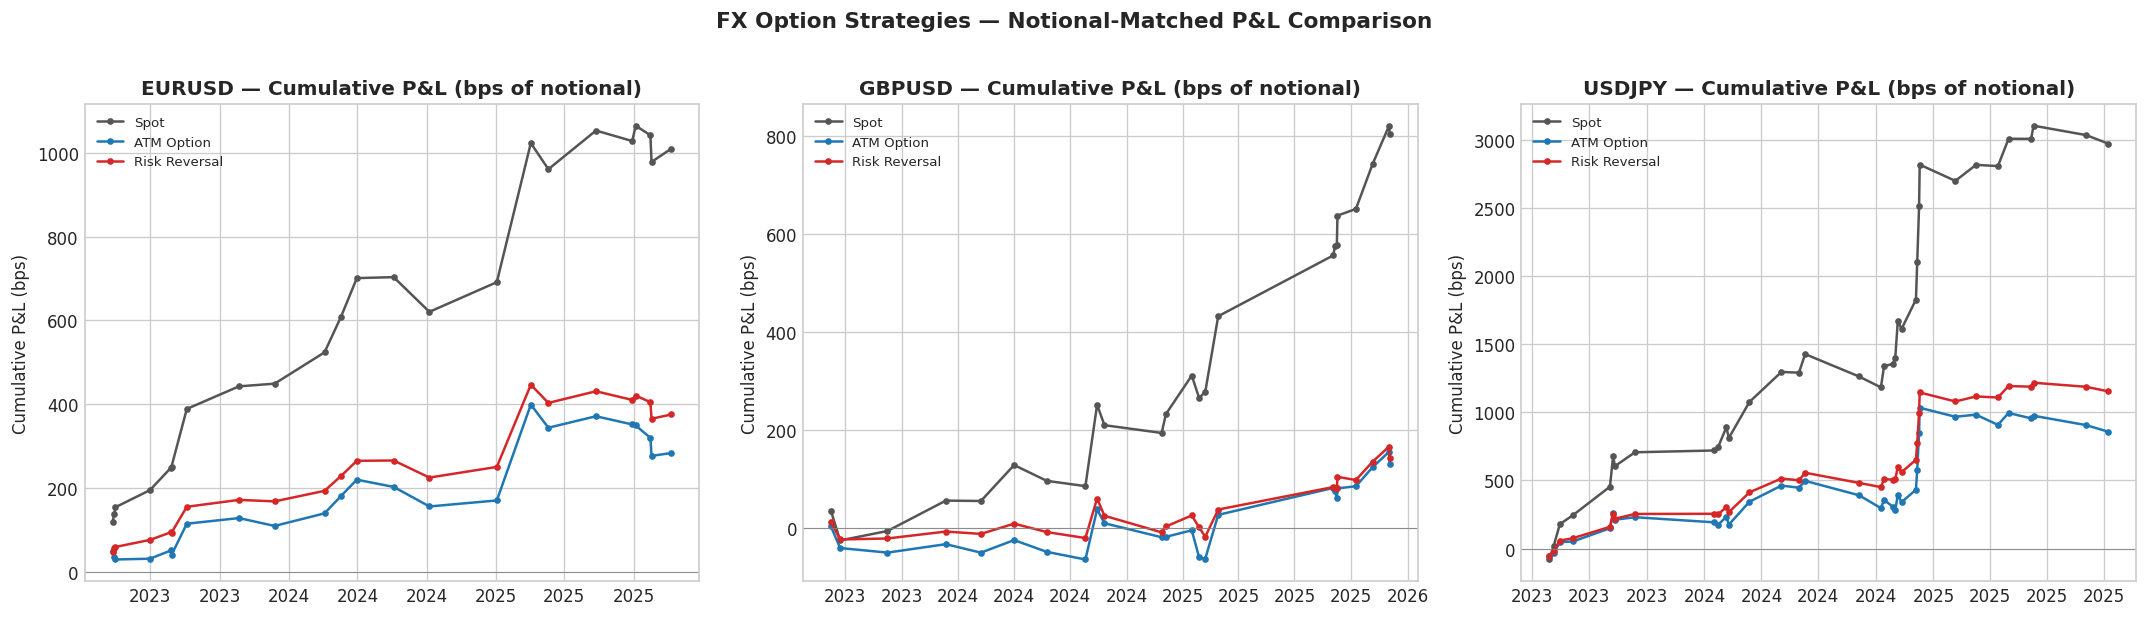


Notional-matched P&L summary:


,N Trades,Spot Total (bps),Option Total (bps),RR Total (bps),Opt/Spot Ratio,RR/Spot Ratio
Pair,,,,,,
EURUSD,23,1010.4,283.2,375.4,0.3,0.4
GBPUSD,24,804.0,130.6,143.5,0.2,0.2
USDJPY,35,2971.6,857.3,1153.5,0.3,0.4


In [4]:
# Cell 3: Equity Curves — Notional-Matched Comparison
# =====================================================
#
# All strategies use 1x notional. P&L as fraction of notional (F_entry).
# This shows the raw P&L profile of each strategy.

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colours = {'spot': '#555555', 'option': '#1f77b4', 'rr': '#d62728'}

for i, ccy in enumerate(CURRENCIES):
    trades_df = all_trades[ccy]
    pair = PAIR_MAP[ccy]
    if len(trades_df) == 0:
        continue
    
    ax = axes[i]
    
    # Cumulative P&L in bps of notional
    trades_sorted = trades_df.sort_values('entry_date')
    
    for label, col, colour in [
        ('Spot', 'spot_pnl_bps', colours['spot']),
        ('ATM Option', 'opt_pnl_bps', colours['option']),
        ('Risk Reversal', 'rr_pnl_bps', colours['rr']),
    ]:
        cum = trades_sorted[col].cumsum()
        ax.plot(trades_sorted['entry_date'], cum, color=colour, lw=1.5,
                marker='o', markersize=3, label=label)
    
    ax.axhline(0, color='grey', lw=0.5)
    ax.set_title(f"{pair} — Cumulative P&L (bps of notional)", fontweight='bold')
    ax.set_ylabel('Cumulative P&L (bps)')
    ax.legend(fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('FX Option Strategies — Notional-Matched P&L Comparison',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
summary_rows = []
for ccy in CURRENCIES:
    t = all_trades[ccy]
    if len(t) == 0:
        continue
    summary_rows.append({
        'Pair': PAIR_MAP[ccy],
        'N Trades': len(t),
        'Spot Total (bps)': t['spot_pnl_bps'].sum(),
        'Option Total (bps)': t['opt_pnl_bps'].sum(),
        'RR Total (bps)': t['rr_pnl_bps'].sum(),
        'Opt/Spot Ratio': t['opt_pnl_bps'].sum() / t['spot_pnl_bps'].sum()
            if t['spot_pnl_bps'].sum() != 0 else np.nan,
        'RR/Spot Ratio': t['rr_pnl_bps'].sum() / t['spot_pnl_bps'].sum()
            if t['spot_pnl_bps'].sum() != 0 else np.nan,
    })

print('\nNotional-matched P&L summary:')
display(pd.DataFrame(summary_rows).set_index('Pair').round(1))

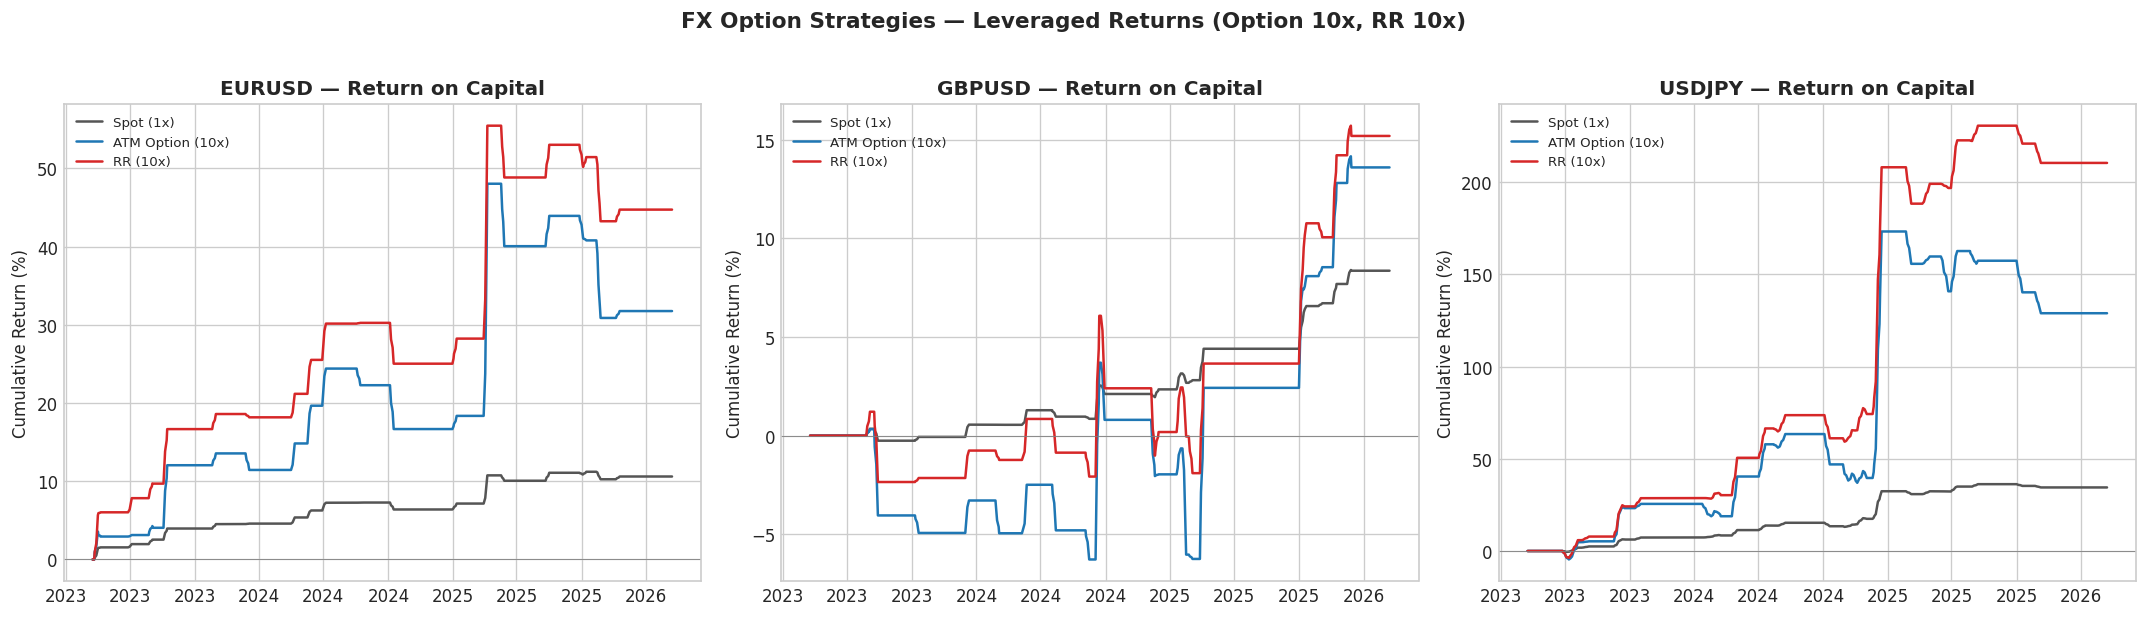


Leverage configuration:
  Spot:       1x (capital = 100% of notional)
  EURUSD Option: 10x (premium = 8.6% of capital per trade)
  GBPUSD Option: 10x (premium = 8.2% of capital per trade)
  USDJPY Option: 10x (premium = 11.6% of capital per trade)
  RR:         10x (margin = 30% of capital per trade)


In [5]:
# Cell 4: Capital-Efficient (Leveraged) Equity Curves
# =====================================================
#
# Options require less capital than spot for the same notional exposure.
# We model a fund that takes on N× its capital as notional per trade,
# with P&L accruing to the fund.
#
# Practical leverage limits:
#   ATM option: premium ≈ 0.8-1.2% of notional → max leverage = 1/0.01 ≈ 100x
#   Risk reversal: margin ≈ 3% of notional → max leverage = 1/0.03 ≈ 33x
#
# We use moderate leverage: 10x for both (well within capital constraints).
# At 10x: option premium = 10 × ~1% = 10% of capital per trade (conservative).
#          RR margin = 10 × 3% = 30% of capital per trade (moderate).

OPTION_LEVERAGE = 10
RR_LEVERAGE = 10

# Build daily return series per strategy per pair
daily_series = {}

for ccy in CURRENCIES:
    trades_df = all_trades[ccy]
    pair = PAIR_MAP[ccy]
    config = pair_data[ccy]['config']
    hold_days = config['hold_days']
    if len(trades_df) == 0:
        continue
    
    # Get the full date range from spot data
    df = pair_data[ccy]['df']
    dates = pd.DatetimeIndex(sorted(df['date'].dropna().unique()))
    
    # Initialise daily returns (0 = flat)
    spot_daily = pd.Series(0.0, index=dates, name=f'{pair}_spot')
    option_daily = pd.Series(0.0, index=dates, name=f'{pair}_option')
    rr_daily = pd.Series(0.0, index=dates, name=f'{pair}_rr')
    
    for _, trade in trades_df.iterrows():
        entry = trade['entry_date']
        
        # Distribute P&L evenly over hold period
        hold_dates = dates[(dates >= entry) & (dates < entry + pd.Timedelta(days=hold_days + 2))]
        hold_dates = hold_dates[:hold_days]
        n_hold = len(hold_dates)
        if n_hold == 0:
            continue
        
        # All returns expressed as fraction of fund capital per day
        # Spot: 1x leverage (capital = notional)
        spot_daily.loc[hold_dates] += (trade['spot_pnl'] / trade['F_entry']) / n_hold
        
        # Option: Nx leverage (capital = notional / N, so P&L / capital = N × P&L / notional)
        option_daily.loc[hold_dates] += OPTION_LEVERAGE * (trade['opt_net_pnl'] / trade['F_entry']) / n_hold
        
        # RR: Nx leverage
        rr_daily.loc[hold_dates] += RR_LEVERAGE * (trade['rr_net_pnl'] / trade['F_entry']) / n_hold
    
    daily_series[ccy] = {
        'spot': spot_daily,
        'option': option_daily,
        'rr': rr_daily,
    }

# --- Plot leveraged equity curves ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colours = {'spot': '#555555', 'option': '#1f77b4', 'rr': '#d62728'}

for i, ccy in enumerate(CURRENCIES):
    if ccy not in daily_series:
        continue
    pair = PAIR_MAP[ccy]
    ax = axes[i]
    
    for label, key, colour in [
        ('Spot (1x)', 'spot', colours['spot']),
        (f'ATM Option ({OPTION_LEVERAGE}x)', 'option', colours['option']),
        (f'RR ({RR_LEVERAGE}x)', 'rr', colours['rr']),
    ]:
        s = daily_series[ccy][key]
        cum = (1 + s).cumprod()
        ax.plot(cum.index, (cum - 1) * 100, color=colour, lw=1.5, label=label)
    
    ax.axhline(0, color='grey', lw=0.5)
    ax.set_title(f"{pair} — Return on Capital", fontweight='bold')
    ax.set_ylabel('Cumulative Return (%)')
    ax.legend(fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle(f'FX Option Strategies — Leveraged Returns (Option {OPTION_LEVERAGE}x, RR {RR_LEVERAGE}x)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print leverage / capital summary
print(f'\nLeverage configuration:')
print(f'  Spot:       1x (capital = 100% of notional)')
for ccy in CURRENCIES:
    t = all_trades[ccy]
    if len(t) > 0:
        avg_prem_pct = t['opt_premium'].mean() / t['F_entry'].mean()
        print(f'  {PAIR_MAP[ccy]} Option: {OPTION_LEVERAGE}x '
              f'(premium = {OPTION_LEVERAGE * avg_prem_pct * 100:.1f}% of capital per trade)')
print(f'  RR:         {RR_LEVERAGE}x (margin = {RR_LEVERAGE * 3:.0f}% of capital per trade)')

FX Skew Divergence — Option Strategy KPIs


Pair             EURUSD                  GBPUSD                  USDJPY  \
Strategy           Spot ATM Option    RR   Spot ATM Option    RR   Spot   
Total Return (%)   10.6       31.8  44.7    8.4       13.6  15.2   34.5   
CAGR (%)            3.4        9.6  13.1    2.7        4.3   4.8   10.4   
Volatility (%)      1.3        7.8   6.8    0.9        4.9   3.9    2.5   
Sharpe             1.65       1.23  1.96   1.09       0.59  0.86   3.26   
Sortino            2.70       1.45  2.30   1.59       0.56  0.93   8.19   
Calmar             3.96       0.83  1.67   4.50       0.45  0.64   5.40   
Max DD (%)         -0.9      -11.6  -7.9   -0.6       -9.6  -7.5   -1.9   
Max DD Days          98        188   188    107        253   252    119   
Win Rate (%)       12.8        9.7  11.7   10.1        8.3   8.6   21.6   

Pair                                
Strategy         ATM Option     RR  
Total Return (%)      129.0  210.5  
CAGR (%)               31.8   45.9  
Volatility (%)         14.1   11.7  
Sharpe                 1.92   3.18  
Sortino                5.42   7.84  
Calmar                 1.96   5.54  
Max DD (%)            -16.2   -8.3  
Max DD Days             263    119  
Win Rate (%)           16.3   19.4


CAGR Improvement Summary:
  EURUSD: Spot 3.4% -> Option 9.6% (2.8x) -> RR 13.1%
  GBPUSD: Spot 2.7% -> Option 4.3% (1.6x) -> RR 4.8%
  USDJPY: Spot 10.4% -> Option 31.8% (3.1x) -> RR 45.9%



ANNUAL RETURN BREAKDOWN BY YEAR



Year                 2023     2024    2025   2026    Total
Pair   Strategy                                           
EURUSD ATM Option  +11.4%    +4.7%  +12.9%  +0.0%   +31.8%
       RR          +18.2%    +5.8%  +15.8%  +0.0%   +44.7%
       Spot         +4.6%    +1.7%   +4.0%  +0.0%   +10.6%
GBPUSD ATM Option   -3.3%    +1.4%  +15.9%  +0.0%   +13.6%
       RR           -0.8%    +0.9%  +15.0%  +0.0%   +15.2%
       Spot         +0.6%    +1.8%   +5.9%  +0.0%    +8.4%
USDJPY ATM Option  +25.5%  +117.7%  -16.2%  +0.0%  +129.0%
       RR          +28.6%  +139.5%   +0.8%  +0.0%  +210.5%
       Spot         +7.3%   +23.4%   +1.6%  +0.0%   +34.5%

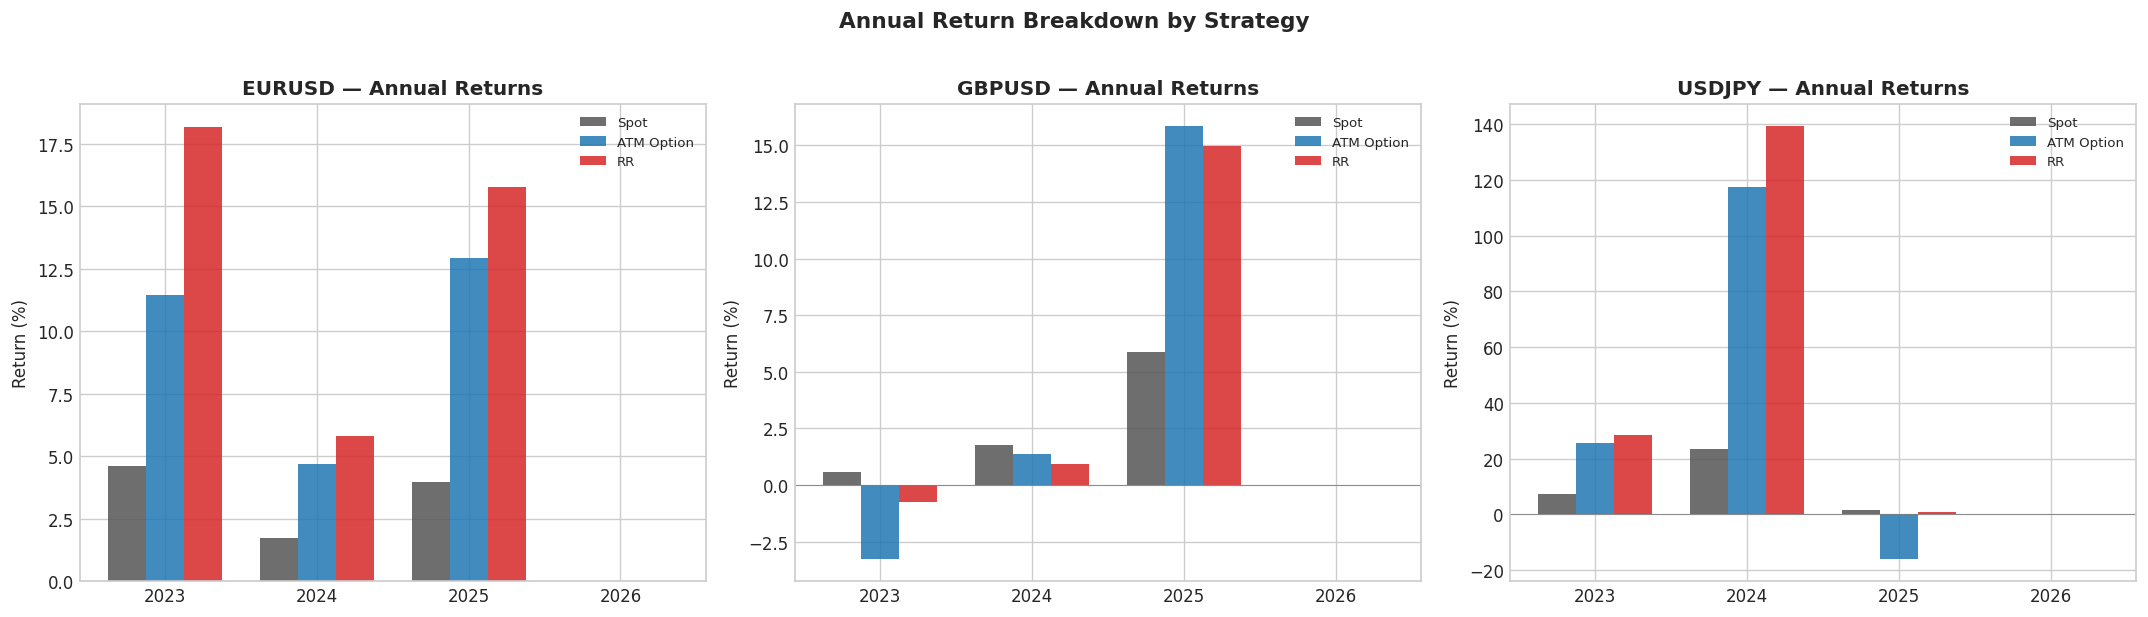

In [6]:
# Cell 5: Full KPI Comparison Table + Annual Return Breakdown
# =============================================================

pm = PerformanceMetrics(risk_free_rate=0.02)

kpi_rows = []

for ccy in CURRENCIES:
    if ccy not in daily_series:
        continue
    pair = PAIR_MAP[ccy]
    
    for strat_label, strat_key in [
        ('Spot', 'spot'),
        ('ATM Option', 'option'),
        ('RR', 'rr'),
    ]:
        s = daily_series[ccy][strat_key]
        cum = (1 + s).cumprod()
        
        metrics = pm.calculate_all_metrics(cum, s)
        
        kpi_rows.append({
            'Pair': pair,
            'Strategy': strat_label,
            'Total Return (%)': metrics['total_return'] * 100,
            'CAGR (%)': metrics['cagr'] * 100,
            'Volatility (%)': metrics['volatility'] * 100,
            'Sharpe': metrics['sharpe_ratio'],
            'Sortino': metrics['sortino_ratio'],
            'Calmar': metrics['calmar_ratio'],
            'Max DD (%)': metrics['max_drawdown'] * 100,
            'Max DD Days': metrics['max_drawdown_duration'],
            'Win Rate (%)': metrics['win_rate'] * 100,
        })

kpi = pd.DataFrame(kpi_rows)
kpi_pivot = kpi.set_index(['Pair', 'Strategy']).T

# Format
fmt = kpi_pivot.copy()
pct_rows = ['Total Return (%)', 'CAGR (%)', 'Volatility (%)', 'Max DD (%)', 'Win Rate (%)']
dec_rows = ['Sharpe', 'Sortino', 'Calmar']
for r in pct_rows:
    if r in fmt.index:
        fmt.loc[r] = fmt.loc[r].apply(lambda x: f"{x:.1f}")
for r in dec_rows:
    if r in fmt.index:
        fmt.loc[r] = fmt.loc[r].apply(lambda x: f"{x:.2f}")
if 'Max DD Days' in fmt.index:
    fmt.loc['Max DD Days'] = fmt.loc['Max DD Days'].apply(lambda x: f"{int(x)}")

print('FX Skew Divergence — Option Strategy KPIs')
print('=' * 70)
display(fmt)

# CAGR improvement summary
print('\nCAGR Improvement Summary:')
for ccy in CURRENCIES:
    pair = PAIR_MAP[ccy]
    pair_kpi = kpi[kpi['Pair'] == pair]
    spot_cagr = pair_kpi.loc[pair_kpi['Strategy'] == 'Spot', 'CAGR (%)'].values
    opt_cagr = pair_kpi.loc[pair_kpi['Strategy'] == 'ATM Option', 'CAGR (%)'].values
    rr_cagr = pair_kpi.loc[pair_kpi['Strategy'] == 'RR', 'CAGR (%)'].values
    if len(spot_cagr) > 0 and len(opt_cagr) > 0:
        ratio = opt_cagr[0] / spot_cagr[0] if spot_cagr[0] != 0 else np.nan
        print(f"  {pair}: Spot {spot_cagr[0]:.1f}% -> Option {opt_cagr[0]:.1f}% "
              f"({ratio:.1f}x) -> RR {rr_cagr[0]:.1f}%")

# =====================================================
# Annual Return Breakdown per Year per Strategy
# =====================================================

print('\n\n')
print('=' * 70)
print('ANNUAL RETURN BREAKDOWN BY YEAR')
print('=' * 70)

annual_rows = []
for ccy in CURRENCIES:
    if ccy not in daily_series:
        continue
    pair = PAIR_MAP[ccy]
    
    for strat_label, strat_key in [
        ('Spot', 'spot'),
        ('ATM Option', 'option'),
        ('RR', 'rr'),
    ]:
        s = daily_series[ccy][strat_key]
        # Annual returns: compound daily returns per calendar year
        annual = s.groupby(s.index.year).apply(lambda x: (1 + x).prod() - 1) * 100
        for year, ret in annual.items():
            annual_rows.append({
                'Pair': pair,
                'Strategy': strat_label,
                'Year': int(year),
                'Return (%)': ret,
            })

annual_df = pd.DataFrame(annual_rows)
annual_pivot = annual_df.pivot_table(
    index=['Pair', 'Strategy'], columns='Year', values='Return (%)'
)
# Add a Total column (cumulative over all years)
annual_pivot['Total'] = annual_pivot.apply(
    lambda row: ((1 + row.dropna() / 100).prod() - 1) * 100, axis=1
)

# Display formatted
annual_fmt = annual_pivot.copy()
annual_fmt = annual_fmt.map(lambda x: f"{x:+.1f}%" if not pd.isna(x) else "—")

print()
display(annual_fmt)

# Also show a per-pair summary chart
years = sorted(annual_df['Year'].unique())
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
bar_colours = {'Spot': '#555555', 'ATM Option': '#1f77b4', 'RR': '#d62728'}
bar_width = 0.25

for i, ccy in enumerate(CURRENCIES):
    pair = PAIR_MAP[ccy]
    ax = axes[i]
    pair_annual = annual_df[annual_df['Pair'] == pair]
    
    for j, strat in enumerate(['Spot', 'ATM Option', 'RR']):
        strat_data = pair_annual[pair_annual['Strategy'] == strat]
        x_pos = np.arange(len(years)) + j * bar_width
        vals = [strat_data.loc[strat_data['Year'] == y, 'Return (%)'].values[0]
                if len(strat_data.loc[strat_data['Year'] == y]) > 0 else 0
                for y in years]
        ax.bar(x_pos, vals, bar_width, label=strat, color=bar_colours[strat], alpha=0.85)
    
    ax.set_xticks(np.arange(len(years)) + bar_width)
    ax.set_xticklabels(years)
    ax.set_title(f'{pair} — Annual Returns', fontweight='bold')
    ax.set_ylabel('Return (%)')
    ax.axhline(0, color='grey', lw=0.5)
    ax.legend(fontsize=8)

fig.suptitle('Annual Return Breakdown by Strategy',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Combined Portfolio (Equal-Weight All 3 Pairs) — Return on Capital


,Total Return (%),CAGR (%),Volatility (%),Sharpe,Sortino,Calmar,Max DD (%)
Strategy,,,,,,,
Spot,17.3,5.5,1.0,3.39,7.50,5.17,-1.1
ATM Option,52.0,15.0,5.6,2.15,5.28,1.80,-8.3
Risk Reversal,74.0,20.3,4.7,3.53,7.42,3.85,-5.3



Combined Portfolio — Annual Returns:


Year,2023,2024,2025,2026,Total
Strategy,,,,,
ATM Option,+10.7%,+33.0%,+3.3%,+0.0%,+52.0%
Risk Reversal,+14.8%,+37.3%,+10.4%,+0.0%,+74.0%
Spot,+4.1%,+8.5%,+3.8%,+0.0%,+17.3%


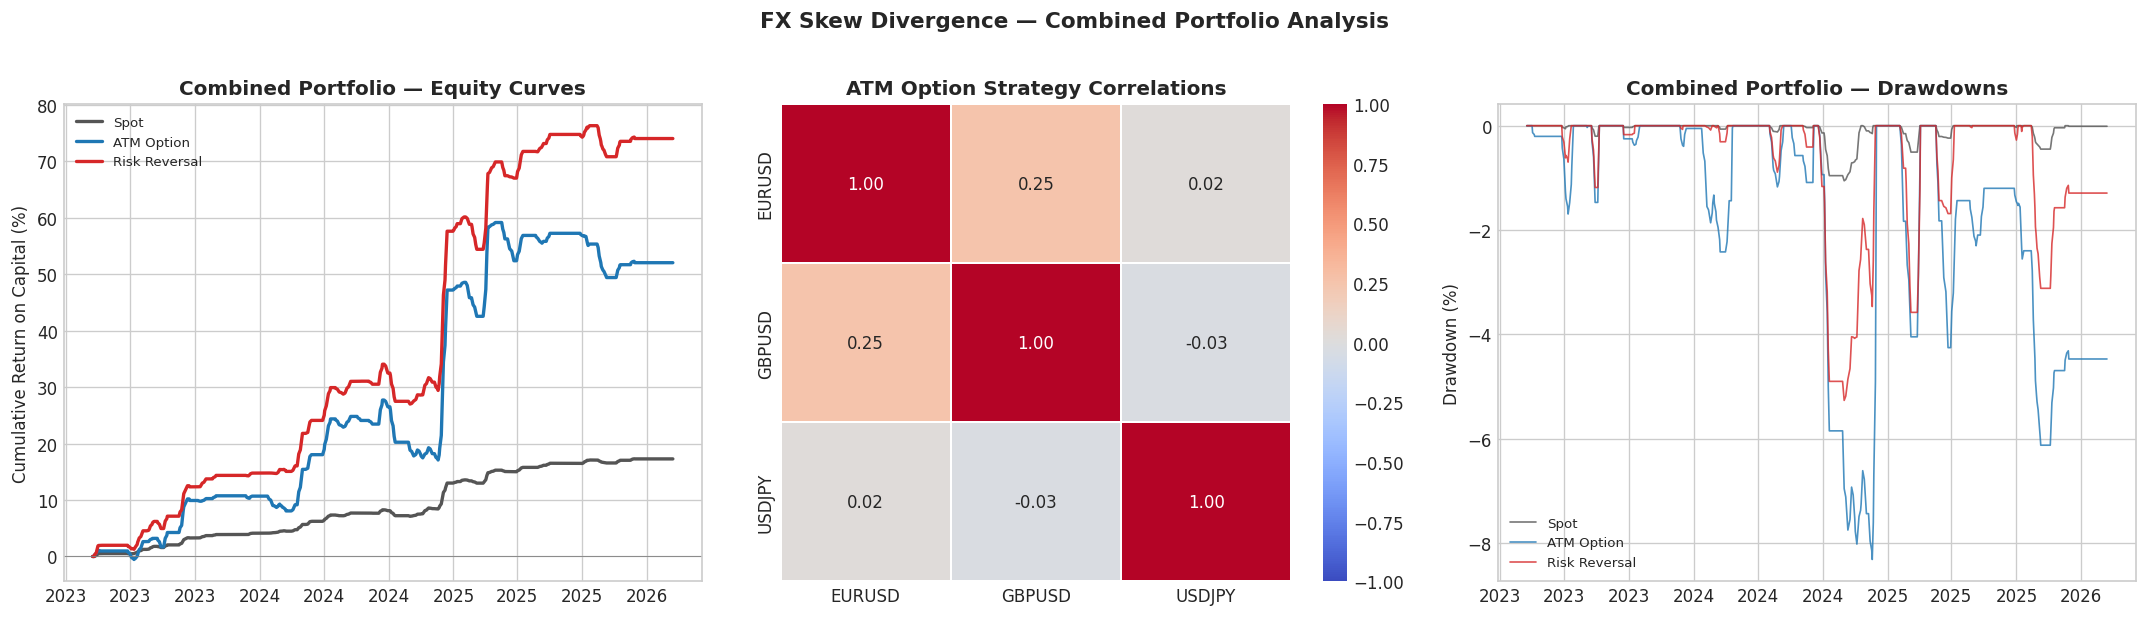


SUMMARY

Spot baseline:   CAGR 5.5%  |  Sharpe 3.39
ATM Option:      CAGR 15.0%  |  Sharpe 2.15
Risk Reversal:   CAGR 20.3%  |  Sharpe 3.53

Option leverage amplifies returns while preserving the signal edge.
Risk reversals provide the highest capital efficiency at the cost of
unlimited downside risk on the short leg.


In [7]:
# Cell 6: Combined Portfolio & Conclusion
# =========================================

# Equal-weight combined portfolio — compare option vs RR vs spot
combined_data = {}
for strat_key in ['spot', 'option', 'rr']:
    strat_rets = {}
    for ccy in CURRENCIES:
        if ccy in daily_series:
            strat_rets[PAIR_MAP[ccy]] = daily_series[ccy][strat_key]
    strat_df = pd.DataFrame(strat_rets).fillna(0)
    strat_df['Combined'] = strat_df.mean(axis=1)
    strat_df['cum'] = (1 + strat_df['Combined']).cumprod()
    combined_data[strat_key] = strat_df

# KPIs for all combined strategies
pm = PerformanceMetrics(risk_free_rate=0.02)
combined_kpi_rows = []
strat_labels = {'spot': 'Spot', 'option': 'ATM Option', 'rr': 'Risk Reversal'}

for strat_key, label in strat_labels.items():
    cdf = combined_data[strat_key]
    metrics = pm.calculate_all_metrics(cdf['cum'], cdf['Combined'])
    combined_kpi_rows.append({
        'Strategy': label,
        'Total Return (%)': f"{metrics['total_return']*100:.1f}",
        'CAGR (%)': f"{metrics['cagr']*100:.1f}",
        'Volatility (%)': f"{metrics['volatility']*100:.1f}",
        'Sharpe': f"{metrics['sharpe_ratio']:.2f}",
        'Sortino': f"{metrics['sortino_ratio']:.2f}",
        'Calmar': f"{metrics['calmar_ratio']:.2f}",
        'Max DD (%)': f"{metrics['max_drawdown']*100:.1f}",
    })

print('Combined Portfolio (Equal-Weight All 3 Pairs) — Return on Capital')
print('=' * 70)
display(pd.DataFrame(combined_kpi_rows).set_index('Strategy'))

# --- Annual breakdown for combined portfolio ---
print('\nCombined Portfolio — Annual Returns:')
annual_combined = []
for strat_key, label in strat_labels.items():
    s = combined_data[strat_key]['Combined']
    annual = s.groupby(s.index.year).apply(lambda x: (1 + x).prod() - 1) * 100
    for year, ret in annual.items():
        annual_combined.append({
            'Strategy': label,
            'Year': int(year),
            'Return (%)': ret,
        })

annual_comb_df = pd.DataFrame(annual_combined)
annual_comb_pivot = annual_comb_df.pivot_table(
    index='Strategy', columns='Year', values='Return (%)'
)
annual_comb_pivot['Total'] = annual_comb_pivot.apply(
    lambda row: ((1 + row.dropna() / 100).prod() - 1) * 100, axis=1
)
annual_comb_fmt = annual_comb_pivot.map(
    lambda x: f"{x:+.1f}%" if not pd.isna(x) else "—"
)
display(annual_comb_fmt)

# --- Plots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Combined equity curves for all 3 strategies
ax = axes[0]
strat_colours = {'spot': '#555555', 'option': '#1f77b4', 'rr': '#d62728'}
for strat_key, label in strat_labels.items():
    cum = combined_data[strat_key]['cum']
    ax.plot(cum.index, (cum - 1) * 100, color=strat_colours[strat_key],
            lw=2, label=label)
ax.set_title('Combined Portfolio — Equity Curves', fontweight='bold')
ax.set_ylabel('Cumulative Return on Capital (%)')
ax.legend(fontsize=8)
ax.axhline(0, color='grey', lw=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# (b) Correlation matrix (option strategy across pairs)
ax = axes[1]
opt_df = combined_data['option']
pair_cols = [PAIR_MAP[c] for c in CURRENCIES if c in daily_series]
corr = opt_df[pair_cols].corr()
sns.heatmap(corr, ax=ax, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, linewidths=1)
ax.set_title('ATM Option Strategy Correlations', fontweight='bold')

# (c) Drawdown comparison
ax = axes[2]
for strat_key, label in strat_labels.items():
    cum = combined_data[strat_key]['cum']
    dd = (cum / cum.cummax() - 1) * 100
    ax.plot(dd.index, dd, color=strat_colours[strat_key], lw=1, label=label, alpha=0.8)
ax.set_title('Combined Portfolio — Drawdowns', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('FX Skew Divergence — Combined Portfolio Analysis',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Final summary
print('\n' + '=' * 70)
print('SUMMARY')
print('=' * 70)
spot_metrics = pm.calculate_all_metrics(
    combined_data['spot']['cum'], combined_data['spot']['Combined'])
opt_metrics = pm.calculate_all_metrics(
    combined_data['option']['cum'], combined_data['option']['Combined'])
rr_metrics = pm.calculate_all_metrics(
    combined_data['rr']['cum'], combined_data['rr']['Combined'])

print(f"\nSpot baseline:   CAGR {spot_metrics['cagr']*100:.1f}%  |  Sharpe {spot_metrics['sharpe_ratio']:.2f}")
print(f"ATM Option:      CAGR {opt_metrics['cagr']*100:.1f}%  |  Sharpe {opt_metrics['sharpe_ratio']:.2f}")
print(f"Risk Reversal:   CAGR {rr_metrics['cagr']*100:.1f}%  |  Sharpe {rr_metrics['sharpe_ratio']:.2f}")
print(f"\nOption leverage amplifies returns while preserving the signal edge.")
print(f"Risk reversals provide the highest capital efficiency at the cost of")
print(f"unlimited downside risk on the short leg.")